In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [4]:
from src.dgd.latent import RepresentationLayer
from src.dgd.latent import GaussianMixture
from src.dgd.nn import NB_Module
from src.utils.helpers import set_seed
from src.model.decoder import Decoder
from src.data.no_onehot_flat_dataset import FlattenedDataset

from src.test.no_onehot_mut_predict import prepare_potential_reps # changed
from src.test.no_onehot_mut_predict import learn_new_representation # changed

In [5]:
print(torch.__version__)

2.4.1+cu121


In [6]:
# set random seeds, device and data directory
seed = 1 
set_seed(seed)
num_workers = 8 # add to the data loaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # add gpu to node request

In [7]:
print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "No GPU")

GPU name: No GPU


In [ ]:
# set directory for output files
os.chdir('/path/to...')

In [9]:
# Read data, only HMF
# mut_data = pd.read_csv("SNV_mutation_catalogue_HMF.tsv", sep='\t')

In [10]:
# mut_data = mut_data.iloc[:, 3:] # from column index 3

In [11]:
# we want the data including the tissue type. The "i" column is the original index (a few samples are removed as they werent compatible in the ID)
# mut_data = pd.read_csv("to_dgd.tsv", sep='\t') # 11.08 on GPU 128g and 16 cores
# > 30 min with 500g and 16 cores CPU

In [12]:
#import pyarrow.csv as pv

#table = pv.read_csv("to_dgd.tsv", parse_options=pv.ParseOptions(delimiter="\t"))
#mut_data = table.to_pandas()

In [13]:
#mut_data = pd.read_csv("to_dgd.tsv", sep='\t', engine="pyarrow")

In [14]:
mut_data = pd.read_parquet("to_dgd.parquet") # 15 sec on CPU

In [15]:
mut_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO1001,12,6,5,11,7,4,2,6,2,0,...,2,7,4,5,7,12,5,3,13,Breast-AdenoCa
DO1002,20,4,6,5,11,9,0,4,3,2,...,3,4,0,6,6,6,1,2,7,Breast-AdenoCa
DO1003,13,4,7,6,3,6,0,9,2,0,...,2,6,3,1,6,5,3,3,8,Breast-AdenoCa
DO1004,34,11,19,24,33,13,3,20,2,1,...,11,9,7,10,12,5,7,6,17,Breast-AdenoCa
DO1005,9,5,5,7,9,10,3,9,0,0,...,3,3,3,2,3,5,4,2,4,Breast-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO9700,51,14,40,43,47,17,2,29,4,0,...,4,19,7,14,13,47,27,13,80,ColoRect-AdenoCA
DO9732,76,21,24,47,39,28,0,22,5,3,...,5,9,6,14,15,17,27,12,48,ColoRect-AdenoCA
DO9788,59,10,25,26,26,16,2,20,7,2,...,4,14,6,7,13,39,27,18,65,ColoRect-AdenoCA


In [16]:
# no NaNs
mut_data.isna().sum().sum()

np.int64(0)

In [17]:
#subsample = mut_data.sample(n=500)

In [18]:
# split into train and val/test data
train_data, val_test_data = train_test_split(mut_data, test_size=0.30, random_state=seed, stratify=mut_data['Tumor_Type'])

In [19]:
train_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50420,21,8,7,10,14,4,2,10,2,0,...,2,2,0,2,2,3,4,3,12,Prost-AdenoCA
DO52701,8,3,4,6,5,5,0,5,0,0,...,4,2,0,1,5,10,9,2,27,Lymph-CLL
DO51500,23,4,5,9,17,7,1,1,1,0,...,3,2,0,4,1,9,7,2,14,Panc-AdenoCA
DO10829,3,3,3,1,5,1,0,2,0,1,...,0,0,0,1,1,0,1,0,3,Prost-AdenoCA
DO51069,10,3,4,5,4,5,0,1,0,0,...,2,1,0,0,2,2,1,0,6,Prost-AdenoCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO45239,19,10,8,9,15,5,0,5,2,2,...,1,3,1,0,4,3,4,2,10,Liver-HCC
DO6474,5,3,4,1,0,0,0,3,1,0,...,0,0,0,2,2,0,0,1,3,Lymph-CLL
DO48952,1,0,0,2,0,1,1,1,0,0,...,0,3,1,0,1,0,0,1,2,CNS-Medullo


In [20]:
label_counts = train_data['Tumor_Type'].value_counts()
len(label_counts)

27

In [21]:
counts = train_data['Tumor_Type'].value_counts()
counts # 27 tumor types

Tumor_Type
Liver-HCC           220
Panc-AdenoCA        162
Prost-AdenoCA       139
Breast-AdenoCa      136
Kidney-RCC          100
CNS-Medullo          99
Ovary-AdenoCA        77
Skin-Melanoma        75
Lymph-BNHL           73
Eso-AdenoCa          68
Lymph-CLL            63
CNS-PiloAstro        62
Panc-Endocrine       57
Stomach-AdenoCA      48
Head-SCC             39
ColoRect-AdenoCA     36
Thy-AdenoCA          34
Lung-SCC             33
Uterus-AdenoCA       31
Kidney-ChRCC         30
Bone-Osteosarc       29
CNS-GBM              27
Lung-AdenoCA         26
Biliary-AdenoCA      24
Bone-Leiomyo         24
Myeloid-MPN          16
Bladder-TCC          16
Name: count, dtype: int64

In [22]:
# remove those types with under 2 samples
#val_test_data = val_test_data[~val_test_data["Tumor_Type"].isin(["Myeloid-MPN", "Bladder-TCC", "ColoRect-AdenoCA"])]

In [23]:
counts = val_test_data['Tumor_Type'].value_counts()
counts # 27 tumor types

Tumor_Type
Liver-HCC           94
Panc-AdenoCA        70
Prost-AdenoCA       60
Breast-AdenoCa      59
Kidney-RCC          43
CNS-Medullo         42
Ovary-AdenoCA       33
Lymph-BNHL          32
Skin-Melanoma       32
Eso-AdenoCa         29
Lymph-CLL           27
CNS-PiloAstro       27
Panc-Endocrine      24
Stomach-AdenoCA     20
Head-SCC            17
ColoRect-AdenoCA    16
Thy-AdenoCA         14
Lung-SCC            14
Uterus-AdenoCA      13
Kidney-ChRCC        13
Bone-Osteosarc      12
CNS-GBM             12
Lung-AdenoCA        11
Biliary-AdenoCA     10
Bone-Leiomyo        10
Bladder-TCC          7
Myeloid-MPN          7
Name: count, dtype: int64

In [24]:
validation_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=seed, stratify=val_test_data['Tumor_Type'])

In [25]:
validation_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50837,9,3,4,3,3,4,1,2,0,0,...,1,0,1,0,0,1,0,0,7,Liver-HCC
DO9074,80,18,43,52,36,30,3,14,2,0,...,2,2,1,6,2,9,5,2,35,ColoRect-AdenoCA
DO15398,53,14,17,32,26,18,0,10,2,0,...,5,13,3,5,10,15,4,15,36,Head-SCC
DO46744,5,1,2,0,2,2,0,0,0,0,...,0,0,0,0,1,1,2,0,4,Panc-Endocrine
DO49768,15,2,2,7,7,3,0,7,1,1,...,9,0,3,0,6,12,6,2,28,Kidney-RCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46328,14,1,7,7,13,5,2,7,0,0,...,3,3,2,3,3,4,5,5,17,Ovary-AdenoCA
DO23028,38,16,26,19,26,14,3,32,4,6,...,6,3,3,4,2,7,7,7,14,Liver-HCC
DO48925,2,0,0,2,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,1,CNS-Medullo


In [26]:
#validation_data = validation_data.sample(frac=0.1, random_state=1, replace=False)

In [27]:
test_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO51074,14,3,4,5,8,6,0,5,0,0,...,3,0,1,2,0,0,2,0,8,Prost-AdenoCA
DO51496,14,3,8,11,11,5,0,7,1,1,...,2,2,0,1,1,2,2,2,9,Panc-AdenoCA
DO15046,81,38,65,75,49,33,7,41,7,5,...,8,10,14,7,8,13,20,11,64,Head-SCC
DO6558,7,2,0,3,2,0,1,0,2,0,...,0,0,1,0,1,0,0,1,3,Lymph-CLL
DO50410,48,10,38,27,38,22,1,22,4,1,...,7,16,3,8,7,171,92,78,143,Eso-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46400,42,18,21,19,31,15,4,32,4,2,...,2,10,6,13,6,7,2,8,18,Ovary-AdenoCA
DO51514,13,8,11,10,7,10,0,7,1,0,...,0,3,0,8,4,9,6,8,25,Panc-AdenoCA
DO51144,16,2,6,3,10,4,0,8,0,0,...,0,2,0,0,0,2,3,1,10,Prost-AdenoCA


In [28]:
train_data.iloc[0]

AA[C>A]AA                21
AA[C>A]AC                 8
AA[C>A]AG                 7
AA[C>A]AT                10
AA[C>A]CA                14
                  ...      
TT[T>G]TA                 3
TT[T>G]TC                 4
TT[T>G]TG                 3
TT[T>G]TT                12
Tumor_Type    Prost-AdenoCA
Name: DO50420, Length: 1537, dtype: object

In [29]:
# dimensions for features
out_dim = 1

In [30]:
# I'll call it validation loader for now
# train_ratio = 0.9
# train_data = train_val_data .iloc[:int(train_ratio*len(train_val_data )),:]
# validation_data = train_val_data .iloc[int(train_ratio*len(train_val_data )):,:]

#train_data, validation_data = train_test_split(train_val_data, test_size=0.1, random_state=seed, stratify=train_val_data[primaryTumorLocation])

# define scaling for NB
# each sample gets a scaling factor
# scaling factors already built in in Dataset
# scaling_factors = torch.mean(torch.Tensor(train_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)
# validation_scaling_factors = torch.mean(torch.Tensor(validation_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)
# make data loaders
train_loader = torch.utils.data.DataLoader(FlattenedDataset(train_data, scaling_type="mean"),  # num_workers=num_workers
                                          batch_size=1536,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(FlattenedDataset(validation_data, scaling_type="mean"),
                                          batch_size=1536,
                                          shuffle=False)

# The class GeneExpressionDataset also works for samples x mut_type (row x column)

In [31]:
#train_loader.dataset.mut_matrix

In [32]:
len(train_loader.dataset.labels)

1744

In [33]:
1744*1537

2680528

In [34]:
# batches
len(train_loader)

1744

In [35]:
train_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50420,21,8,7,10,14,4,2,10,2,0,...,2,2,0,2,2,3,4,3,12,Prost-AdenoCA
DO52701,8,3,4,6,5,5,0,5,0,0,...,4,2,0,1,5,10,9,2,27,Lymph-CLL
DO51500,23,4,5,9,17,7,1,1,1,0,...,3,2,0,4,1,9,7,2,14,Panc-AdenoCA
DO10829,3,3,3,1,5,1,0,2,0,1,...,0,0,0,1,1,0,1,0,3,Prost-AdenoCA
DO51069,10,3,4,5,4,5,0,1,0,0,...,2,1,0,0,2,2,1,0,6,Prost-AdenoCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO45239,19,10,8,9,15,5,0,5,2,2,...,1,3,1,0,4,3,4,2,10,Liver-HCC
DO6474,5,3,4,1,0,0,0,3,1,0,...,0,0,0,2,2,0,0,1,3,Lymph-CLL
DO48952,1,0,0,2,0,1,1,1,0,0,...,0,3,1,0,1,0,0,1,2,CNS-Medullo


In [36]:
#all_values = train_loader.dataset.mut_matrix.flatten()
#all_values

In [37]:
i = 0
for value, lib, sample_idx, mut_idx in validation_loader:
    print(sample_idx, mut_idx)
    i = i+1
    if i == 10:
        break

tensor([0, 0, 0,  ..., 0, 0, 0]) tensor([   0,    1,    2,  ..., 1533, 1534, 1535])
tensor([1, 1, 1,  ..., 1, 1, 1]) tensor([   0,    1,    2,  ..., 1533, 1534, 1535])
tensor([2, 2, 2,  ..., 2, 2, 2]) tensor([   0,    1,    2,  ..., 1533, 1534, 1535])
tensor([3, 3, 3,  ..., 3, 3, 3]) tensor([   0,    1,    2,  ..., 1533, 1534, 1535])
tensor([4, 4, 4,  ..., 4, 4, 4]) tensor([   0,    1,    2,  ..., 1533, 1534, 1535])
tensor([5, 5, 5,  ..., 5, 5, 5]) tensor([   0,    1,    2,  ..., 1533, 1534, 1535])
tensor([6, 6, 6,  ..., 6, 6, 6]) tensor([   0,    1,    2,  ..., 1533, 1534, 1535])
tensor([7, 7, 7,  ..., 7, 7, 7]) tensor([   0,    1,    2,  ..., 1533, 1534, 1535])
tensor([8, 8, 8,  ..., 8, 8, 8]) tensor([   0,    1,    2,  ..., 1533, 1534, 1535])
tensor([9, 9, 9,  ..., 9, 9, 9]) tensor([   0,    1,    2,  ..., 1533, 1534, 1535])


In [38]:
#all_values.shape

In [39]:
n_tissues = len(mut_data["Tumor_Type"].unique())
n_tissues

27

In [40]:
# hyperparameters
latent_dim = 20
decoder_latent_dim = 40 # double latent_dim as the two reps are concatenated
hidden_dims = [100, 100, 100]
reduction_type = "mean" # output loss reduction

In [41]:
# decoder setup

# set up an output module for the mutation data
gex_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], out_dim) # input and output (mutation counts) for the last layer
    )
output_gex_layer = NB_Module(gex_out_fc, out_dim, scaling_type="mean") # negative binomial of final output
output_gex_layer.n_features = out_dim

# set up the decoder
decoder = Decoder(decoder_latent_dim, hidden_dims, [output_gex_layer]).to(device)

In [42]:
palette = {
    "Biliary-AdenoCA": "#00CD66",
    "Bladder-TCC": "#EEAD0E",
    "Bone-Epith": "#ADAC44",
    "Bone-Leiomyo": "green", # I added
    "Bone-Osteosarc": "#FFD700",
    "Breast-AdenoCa": "#CD6090",
    "CNS-GBM": "#3D3D3D",
    "CNS-Medullo": "#D8BFD8",
    "CNS-Oligo": "#787878",
    "CNS-PiloAstro": "#B0B0B0",
    "Cervix-SCC": "#79CDCD",
    "ColoRect-AdenoCA": "#191970",
    "Eso-AdenoCa": "#1E90FF",
    "Head-SCC": "#8B2323",
    "Kidney-ChRCC": "#B32F0B",
    "Kidney-RCC": "#FF4500",
    "Liver-HCC": "#006400",
    "Lung-AdenoCA": "#FFFFFF",
    "Lung-SCC": "#FDF5E6",
    "Lymph-BNHL": "#698B22",
    "Lymph-CLL": "#F4A35D",
    "Myeloid-AML": "#CD6600",
    "Myeloid-MPN": "#FFC100",
    "Ovary-AdenoCA": "#008B8B",
    "Panc-AdenoCA": "#7A378B",
    "Panc-Endocrine": "#E066FF",
    "Prost-AdenoCA": "#87CEFA",
    "Skin-Melanoma": "#000000",
    "SoftTissue-Leiomyo": "#FFEC8B",
    "SoftTissue-Liposarc": "#CDCB50",
    "Stomach-AdenoCA": "#BFEFFF",
    "Thy-AdenoCA": "#9370DB",
    "Uterus-AdenoCA": "#FF8C69"
}

In [43]:
# combine everything in one class (if desired)

class DGD(nn.Module):
    def __init__(self,decoder,n_mix,mut_n_mix,rep_dim,mut_rep_dim,gmm_spec={},mut_gmm_spec={}):
        super(DGD, self).__init__()
        self.decoder=decoder
        self.rep_dim=rep_dim      # Dimension of representation
        self.mut_rep_dim=mut_rep_dim  
        
        self.gmm=GaussianMixture(n_mix,rep_dim,**gmm_spec)
        self.train_rep=None
        self.val_rep=None
        self.test_rep=None

        # Added for mutation representation
        self.mut_gmm=GaussianMixture(mut_n_mix,mut_rep_dim,**mut_gmm_spec)
        self.mut_train_rep=None
        self.mut_val_rep=None
        self.mut_test_rep=None

    def forward(self,z,mut_z):
        # Concatenate sample and mutation representations
        combined_z = torch.cat((z, mut_z), dim=1)
        return self.decoder(combined_z)

    def loss(self,combined_z,z,mut_z,y,target,scale,gmm_loss=True,mut_gmm_loss=True,reduction="mean"):
        self.dec_loss = self.decoder.loss(y,target,scale=scale,mod_id=None,feature_ids=None,reduction=reduction) # add key for scale and the rest, not necessary before adding mut rep, why?
        if gmm_loss:
            self.gmm_loss = self.gmm(z)
            self.mut_gmm_loss = self.mut_gmm(mut_z)
            if reduction=="mean":
                self.gmm_loss = self.gmm_loss.mean()
                self.mut_gmm_loss = self.mut_gmm_loss.mean()
            elif reduction=="sum":
                self.gmm_loss = self.gmm_loss.sum()
                self.mut_gmm_loss = self.mut_gmm_loss.sum()
            return self.dec_loss, self.gmm_loss, self.mut_gmm_loss
        else:
            return self.dec_loss, None, None
    
    def forward_and_loss(self,z,mut_z,target,scale,gmm_loss=True,mut_gmm_loss=True,reduction="mean"):
        combined_z = torch.cat((z, mut_z), dim=1)
        y = self.decoder(combined_z) # decoder output
        return self.loss(combined_z,z,mut_z,y,target,scale,gmm_loss,mut_gmm_loss,reduction) # Outputs the decoder reconstruction loss and both gmm losses.
    
    def get_representations(self, rep_type="sample", type="train"):   # The one I use. Detached from the computation graph. Added rep_type.
        if rep_type == "sample":
            if type == "train":
                return self.train_rep.z.detach().cpu().numpy()
            elif type == "val":
                return self.val_rep.z.detach().cpu().numpy()
            elif type == "test":
                return self.test_rep.z.detach().cpu().numpy()
        if rep_type == "mutation":
            if type == "train":
                return self.mut_train_rep.mut_z.detach().cpu().numpy()
            elif type == "val":
                return self.mut_val_rep.mut_z.detach().cpu().numpy()
            elif type == "test":
                return self.mut_test_rep.mut_z.detach().cpu().numpy()
        
    def get_gmm_means(self, rep_type="sample"): # Added rep_type
        if rep_type == "sample":
            return self.gmm.mean.detach().cpu().numpy()
        if rep_type == "mutation":
            return self.mut_gmm.mean.detach().cpu().numpy()
    
    def get_latent_space_values(self, rep_type="sample", type="train", n_samples=1000): # Cloned and isolated from the original tensors. Added rep_type.
        # get representations    
        if rep_type == "sample":
            if type=="train":
                rep = self.train_rep.z.clone().detach().cpu().numpy()
            elif type=="val":
                rep = self.val_rep.z.clone().detach().cpu().numpy()
            elif type=="test":
                rep = self.test_rep.z.clone().detach().cpu().numpy()
            
            # get gmm means
            gmm_means = self.gmm.mean.clone().detach().cpu().numpy()
    
            # get some gmm samples
            gmm_samples = self.gmm.sample(n_samples).detach().cpu().numpy()
            
        if rep_type == "mutation":
            if type=="train":
                rep = self.mut_train_rep.z.clone().detach().cpu().numpy() # mut_z or z? just z
            elif type=="val":
                rep = self.mut_val_rep.z.clone().detach().cpu().numpy()
            elif type=="test":
                rep = self.mut_test_rep.z.clone().detach().cpu().numpy()
            
            # get gmm means
            gmm_means = self.mut_gmm.mean.clone().detach().cpu().numpy()
    
            # get some gmm samples
            gmm_samples = self.mut_gmm.sample(n_samples).detach().cpu().numpy()
    
        return rep, gmm_means, gmm_samples # should I change to separate names for each rep_type? No

In [ ]:
import torch
print(torch.cuda.get_device_name(0))
#print(torch.cuda.get_device_properties(0).tota4l_memory / 1024**3, "GB")

In [ ]:
# write a minimal training function

def train_dgd(dgd, train_data, validation_loader, device, learning_rates={'dec':0.001,'rep':0.01,'gmm':0.01},weight_decay=0.,nepochs=100,pr=1,plot=10,reduction_type="mean"):
    if reduction_type == "mean": 
        tlen=len(train_loader.dataset) # Now no dgd.decoder.n_out_features as there is only one output for the NB, so only one recon loss pr input.
        tlen_gmm=len(train_loader.dataset)*dgd.gmm.n_mix_comp*dgd.gmm.dim
        vlen=len(validation_loader.dataset)
        vlen_gmm=len(validation_loader.dataset)*dgd.gmm.n_mix_comp*dgd.gmm.dim
        
    else: # should also be changed as above
        tlen=len(train_loader)
        tlen_gmm=len(train_loader)
        vlen=len(validation_loader)
        vlen_gmm=len(validation_loader)

    # initialize representations
    Ntrain=train_loader.dataset.num_samples
    if dgd.train_rep is None:
        dgd.train_rep = RepresentationLayer(dgd.rep_dim,Ntrain).to(device) # changed bc of the new flattened dataset format
    Nvalidation=validation_loader.dataset.num_samples
    if dgd.val_rep is None:
        dgd.val_rep = RepresentationLayer(dgd.rep_dim,Nvalidation).to(device)

    # mut reps
    Nmut_train=train_loader.dataset.num_muts # number of features in the training set
    if dgd.mut_train_rep is None:
        dgd.mut_train_rep = RepresentationLayer(dgd.rep_dim,Nmut_train).to(device)
    Nmut_validation=validation_loader.dataset.num_muts
    if dgd.mut_val_rep is None:
        dgd.mut_val_rep = RepresentationLayer(dgd.rep_dim,Nmut_validation).to(device)
        
    print(Ntrain)
    print(Nmut_train)
    
    dec_optimizer = torch.optim.AdamW(dgd.decoder.parameters(), lr=learning_rates['dec'], weight_decay=weight_decay) # add weight_decay
    gmm_optimizer = torch.optim.AdamW(dgd.gmm.parameters(), lr=learning_rates['gmm'])
    train_rep_optimizer = torch.optim.AdamW(dgd.train_rep.parameters(), lr=learning_rates['rep'])
    val_rep_optimizer = torch.optim.AdamW(dgd.val_rep.parameters(), lr=learning_rates['rep'])
    
    # added
    mut_gmm_optimizer = torch.optim.AdamW(dgd.mut_gmm.parameters(), lr=learning_rates['gmm'])
    mut_train_rep_optimizer = torch.optim.AdamW(dgd.mut_train_rep.parameters(), lr=learning_rates['rep'])
    mut_val_rep_optimizer = torch.optim.AdamW(dgd.mut_val_rep.parameters(), lr=learning_rates['rep'])

    loss_tab = {"Epoch":[],"Train recon":[],"Test recon":[],
                "GMM train":[],"GMM test":[],"Mut GMM train":[],"Mut GMM test":[]} # added
    best_loss=1.e20
    gmm_loss=True
    mut_gmm_loss=True


    for epoch in range(nepochs): # also uses library. Doesn't find the best gmm for initial reps like in predict.py as they haven't been trained yet
        loss_tab["Epoch"].append(epoch)
        loss_tab["Train recon"].append(0.)
        loss_tab["GMM train"].append(0.)
        train_rep_optimizer.zero_grad()
        
        # added
        loss_tab["Mut GMM train"].append(0.)
        mut_train_rep_optimizer.zero_grad()
        
        dgd.train()
        
        #batch_count = 0   

        # add mut rep and mut rep gmm
        for x, lib, sample_idx, mut_idx in train_loader: 
            dec_optimizer.zero_grad()
            if gmm_loss: 
                gmm_optimizer.zero_grad()
                mut_gmm_optimizer.zero_grad() # added
            #t0 = time.time()
            recon_loss, gmm_loss, mut_gmm_loss = dgd.forward_and_loss(dgd.train_rep(sample_idx).to(device), dgd.mut_train_rep(mut_idx).to(device), [x.to(device)],[lib.view(-1, 1).to(device)],
                                        gmm_loss=gmm_loss, mut_gmm_loss=mut_gmm_loss,reduction=reduction_type) #
            #print(f"Forward pass took {time.time() - t0:.2f}s")
            loss_tab["Train recon"][-1] += recon_loss.item()
            loss_tab["GMM train"][-1] += gmm_loss.item()
            loss_tab["Mut GMM train"][-1] += mut_gmm_loss.item() # added
            loss = recon_loss + gmm_loss + mut_gmm_loss
            #t0 = time.time()
            loss.backward()
            #print(f"backward took {time.time() - t0:.2f}s")
            dec_optimizer.step()
            if gmm_loss: 
                gmm_optimizer.step()
                mut_gmm_optimizer.step() # added
            #batch_count += 1
            #print(batch_count)
            #return None
        train_rep_optimizer.step()
        mut_train_rep_optimizer.step() # update mut rep after each epoch

        # average loss per sample bc we use sum as reduction type
        loss_tab["Train recon"][-1] /= tlen 
        loss_tab["GMM train"][-1] /= tlen_gmm
        loss_tab["Mut GMM train"][-1] /= tlen_gmm

        
        # Validation data
        loss_tab["Test recon"].append(0.)
        loss_tab["GMM test"].append(0.)
        val_rep_optimizer.zero_grad()

        # added
        loss_tab["Mut GMM test"].append(0.)
        mut_val_rep_optimizer.zero_grad()

        # added
        gmm_loss=True
        mut_gmm_loss=True
        
        dgd.eval()
        for x, lib, sample_idx, mut_idx in validation_loader:
            #print("Sample idx range:", sample_idx.min().item(), sample_idx.max().item())
            #print("Mut idx range:", mut_idx.min().item(), mut_idx.max().item())
            #print("Sample rep shape:", dgd.train_rep.z.shape)
            #print("Mut rep shape:", dgd.mut_train_rep.z.shape)

            recon_loss, gmm_loss, mut_gmm_loss = dgd.forward_and_loss(dgd.val_rep(sample_idx.to(device)),dgd.mut_val_rep(mut_idx.to(device)),[x.to(device)],[lib.view(-1, 1).to(device)],
                                        gmm_loss=gmm_loss, mut_gmm_loss=mut_gmm_loss,reduction=reduction_type) 
            loss_tab["Test recon"][-1] += recon_loss.item()
            loss_tab["GMM test"][-1] += gmm_loss.item()
            loss_tab["Mut GMM test"][-1] += mut_gmm_loss.item()
            loss = recon_loss + gmm_loss + mut_gmm_loss
            #t0 = time.time()
            loss.backward()
            #print(f"backward took {time.time() - t0:.2f}s")
        val_rep_optimizer.step()
        mut_val_rep_optimizer.step()

        loss_tab["Test recon"][-1] /= vlen
        loss_tab["GMM test"][-1] /= vlen_gmm
        loss_tab["Mut GMM test"][-1] /= vlen_gmm

        
        if pr>0 and (epoch+1)%pr==0:
            print(epoch+1, loss_tab["Train recon"][-1], loss_tab["Test recon"][-1])
        if plot>0 and (epoch+1)%plot==0:
            plot_latent_space(*dgd.get_latent_space_values("sample","train",1000),train_loader.dataset.labels,epoch) # 1000 is how many random samples are drawn from the GMM
            mut_plot_latent_space(*dgd.get_latent_space_values("mutation","train",1000),train_loader.dataset.mut_labels,epoch) # The * unpacks the return into separate arguments. Add labels for mutations as well
    
    return loss_tab

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def plot_latent_space(rep, means, samples, labels, epoch):
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)
    
    # Calculate variance explained
    var_exp = pca.explained_variance_ratio_ * 100  # convert to percentage
    pc1_label = f"PC1 ({var_exp[0]:.1f}%)"
    pc2_label = f"PC2 ({var_exp[1]:.1f}%)"
    
    df = pd.DataFrame(rep_pca, columns=["PC1","PC2"])
    df["type"] = "rep"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1","PC2"])
    df_temp["type"] = "samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1","PC2"])
    df_temp["type"] = "means"
    df = pd.concat([df,df_temp])
    # add varinace explained to the axes

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    # add spacing between subplots
    plt.subplots_adjust(wspace=0.4)

    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="type", size="type", sizes=[1,1,10], alpha=0.8, ax=ax[0], palette=["steelblue","orange","black"])
    ax[0].set_title("E"+str(epoch)+": Latent space (by type)")
    ax[0].set_xlabel(pc1_label)
    ax[0].set_ylabel(pc2_label)
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    sns.scatterplot(data=df[df["type"] == "rep"], x="PC1", y="PC2", s=1, alpha=0.8, ax=ax[1], hue="label", palette=palette) 
    ax[1].set_title("E"+str(epoch)+": Latent space (by label)")
    ax[1].set_xlabel(pc1_label)
    ax[1].set_ylabel(pc2_label)
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3)
    
    plt.savefig(f"no_onehot_latent_space_epoch_{epoch}.pdf", bbox_inches='tight', dpi=300)

    plt.show()
    
def mut_plot_latent_space(rep, means, samples, labels, epoch):
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)

    # Calculate variance explained
    var_exp = pca.explained_variance_ratio_ * 100  # convert to percentage
    pc1_label = f"PC1 ({var_exp[0]:.1f}%)"
    pc2_label = f"PC2 ({var_exp[1]:.1f}%)"
    
    df = pd.DataFrame(rep_pca, columns=["PC1","PC2"])
    df["type"] = "rep"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1","PC2"])
    df_temp["type"] = "samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1","PC2"])
    df_temp["type"] = "means"
    df = pd.concat([df,df_temp])
    print(df[df["type"] == "rep"].head())
    print(df.columns)
    print(len(labels), len(rep_pca))

    print(df)

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    # add spacing between subplots
    plt.subplots_adjust(wspace=0.4)

    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="type", size="type", sizes=[1,1,10], alpha=0.8, ax=ax[0], palette=["steelblue","orange","black"])
    ax[0].set_title("E"+str(epoch)+": Latent space (by type)")
    ax[0].set_xlabel(pc1_label) # added
    ax[0].set_ylabel(pc2_label) # added
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    sns.scatterplot(data=df[df["type"] == "rep"], x="PC1", y="PC2", s=1, alpha=0.8, ax=ax[1], hue="label") # add label coloring
    ax[1].set_title("E"+str(epoch)+": Latent space")
    ax[1].set_xlabel(pc1_label) # added
    ax[1].set_ylabel(pc2_label) # added
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3)

    plt.savefig(f"no_onehot_mut_latent_space_epoch_{epoch}.pdf", bbox_inches='tight', dpi=300)
    
    plt.show()

In [138]:
# init a DGD model

gmm_mean_scale = 10 # usually between 2 and 10
sd_mean_init = 0.1 * gmm_mean_scale / n_tissues # 0.2 is empirically good for single-cell data at dimensionality 20

dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        mut_n_mix=6,
        mut_rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1} # the second value in the tuples adds randomness to the initializations
)

In [139]:
sd_mean_init

0.037037037037037035

1744
1536
10 0.0013252196029620387 0.0013431365097822695


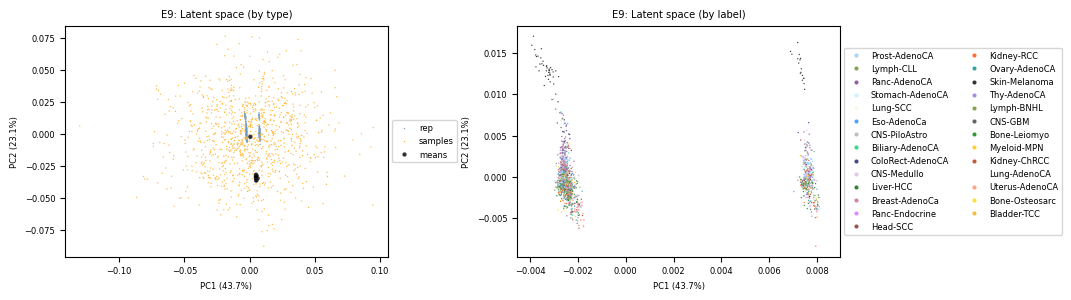

        PC1       PC2 type  label
0 -0.221456 -0.027061  rep  [C>A]
1 -0.043302 -0.030199  rep  [C>A]
2 -0.096058 -0.071889  rep  [C>A]
3 -0.101284 -0.000398  rep  [C>A]
4 -0.125238  0.027012  rep  [C>A]
Index(['PC1', 'PC2', 'type', 'label'], dtype='object')
1536 1536
         PC1       PC2   type  label
0  -0.221456 -0.027061    rep  [C>A]
1  -0.043302 -0.030199    rep  [C>A]
2  -0.096058 -0.071889    rep  [C>A]
3  -0.101284 -0.000398    rep  [C>A]
4  -0.125238  0.027012    rep  [C>A]
..       ...       ...    ...    ...
1  -0.012976  0.022870  means    NaN
2  -0.005218  0.000725  means    NaN
3  -0.013977  0.022478  means    NaN
4  -0.013138  0.023297  means    NaN
5  -0.012158  0.022536  means    NaN

[2542 rows x 4 columns]


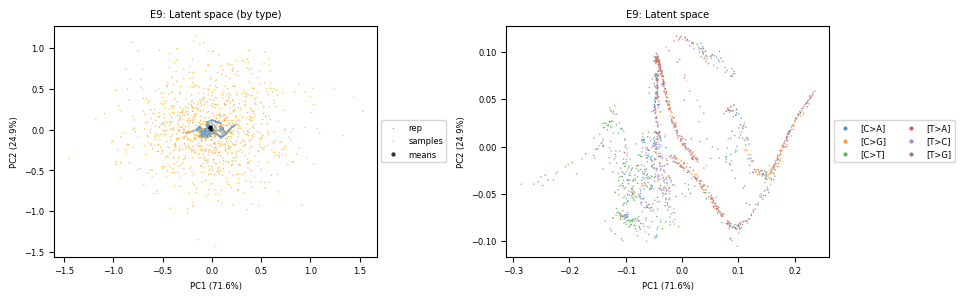

20 0.0013128447899362072 0.0013237391991398435


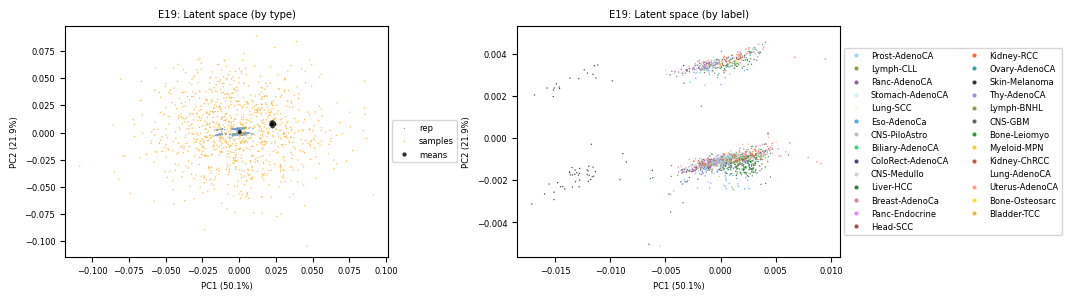

        PC1       PC2 type  label
0 -0.152699 -0.010842  rep  [C>A]
1 -0.029722  0.010456  rep  [C>A]
2 -0.081649 -0.028454  rep  [C>A]
3 -0.094799 -0.005550  rep  [C>A]
4 -0.110407 -0.004130  rep  [C>A]
Index(['PC1', 'PC2', 'type', 'label'], dtype='object')
1536 1536
         PC1       PC2   type  label
0  -0.152699 -0.010842    rep  [C>A]
1  -0.029722  0.010456    rep  [C>A]
2  -0.081649 -0.028454    rep  [C>A]
3  -0.094799 -0.005550    rep  [C>A]
4  -0.110407 -0.004130    rep  [C>A]
..       ...       ...    ...    ...
1  -0.005578  0.018497  means    NaN
2   0.001928  0.002441  means    NaN
3  -0.004535  0.019122  means    NaN
4  -0.005537  0.018948  means    NaN
5  -0.005015  0.019474  means    NaN

[2542 rows x 4 columns]


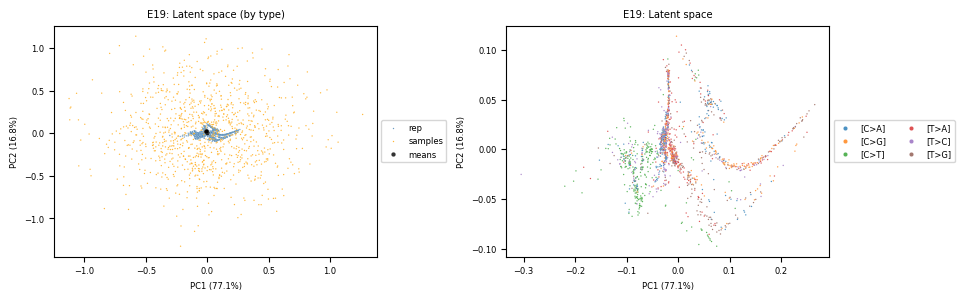

In [ ]:
# train for x epochs and plot learning curves
n_epochs = 50
pr = 10 # how often to print loss
plot = 10

loss_tab = train_dgd(
    dgd, train_data, validation_loader, device,
    learning_rates={'dec':0.0001,'rep':0.01,'gmm':0.01},
    weight_decay=0.001,nepochs=n_epochs,pr=pr,plot=plot,reduction_type=reduction_type
    )

In [ ]:
# make 2 subplots with recon and gmm loss curves
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(loss_tab["Epoch"],loss_tab["Train recon"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["Test recon"],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")
plt.legend()
plt.subplot(1,3,2)
plt.plot(loss_tab["Epoch"],loss_tab["GMM train"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["GMM test"],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")
plt.legend()

# added
plt.subplot(1,3,3)
plt.plot(loss_tab["Epoch"],loss_tab["Mut GMM train"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["Mut GMM test"],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Mut GMM loss")
plt.legend()

plt.subplots_adjust(wspace=0.2)

plt.savefig(f"no_onehot_learning_curves.pdf")

plt.show()

In [ ]:
dgd

In [ ]:
# save the trained model
torch.save(dgd, "no_onehot_mut_dgd_model_1.pth")

# Test representation

In [ ]:
#dgd_model = torch.load("mut_dgd_model_1.pth", map_location=torch.device('cpu'))

In [ ]:
dgd_model = torch.load("no_onehot_mut_dgd_model_1.pth")

In [ ]:
dgd_model

In [47]:
# take test part of mut_data
#test_data = mut_data.loc[X_test.index]
test_data

,AA[C>A]AA,AA[C>A]AC,AA[C>A]AG,AA[C>A]AT,AA[C>A]CA,AA[C>A]CC,AA[C>A]CG,AA[C>A]CT,AA[C>A]GA,AA[C>A]GC,...,TT[T>G]CT,TT[T>G]GA,TT[T>G]GC,TT[T>G]GG,TT[T>G]GT,TT[T>G]TA,TT[T>G]TC,TT[T>G]TG,TT[T>G]TT,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO51074,14,3,4,5,8,6,0,5,0,0,...,3,0,1,2,0,0,2,0,8,Prost-AdenoCA
DO51496,14,3,8,11,11,5,0,7,1,1,...,2,2,0,1,1,2,2,2,9,Panc-AdenoCA
DO15046,81,38,65,75,49,33,7,41,7,5,...,8,10,14,7,8,13,20,11,64,Head-SCC
DO6558,7,2,0,3,2,0,1,0,2,0,...,0,0,1,0,1,0,0,1,3,Lymph-CLL
DO50410,48,10,38,27,38,22,1,22,4,1,...,7,16,3,8,7,171,92,78,143,Eso-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46400,42,18,21,19,31,15,4,32,4,2,...,2,10,6,13,6,7,2,8,18,Ovary-AdenoCA
DO51514,13,8,11,10,7,10,0,7,1,0,...,0,3,0,8,4,9,6,8,25,Panc-AdenoCA
DO51144,16,2,6,3,10,4,0,8,0,0,...,0,2,0,0,0,2,3,1,10,Prost-AdenoCA


# test_loader = torch.utils.data.DataLoader(FlattenedDataset(test_data, scaling_type="mean"), # default is scaling_type='mean'
                                          batch_size=1536,
                                          shuffle=False)

In [50]:
# Access the first sample (idx=0)
#mutations, lib, idx = see_test[0] 

# Print the results
#print("Mutations:", mutations)
#print("Library Size (lib):", lib)
#print("Index:", idx)

In [51]:
test_loader.dataset

Should have 100 gaussians for the mut type representation and 27 for the sample reps.
40 latent dimensions in total, 20 for each rep type.

In [52]:
# 80 sec
new_rep = learn_new_representation(dgd_model, 
                             train_loader,
                             test_loader,
                             test_epochs=50,
                             learning_rates=1e-2,
                             weight_decay=0.,
                             betas=(0.5, 0.7),
                             reduction_type="mean",
                             resampling_type="mean")

100%|███████████████████████████████████████████| 50/50 [06:04<00:00,  7.30s/it]


In [54]:
new_rep

RepresentationLayer()

In [55]:
dgd_model.train_rep

RepresentationLayer()

In [56]:
# assign the test representation from the predict function to the test_rep in the dgd model
dgd_model.test_rep = new_rep

In [57]:
dgd_test = dgd_model.get_representations(type="test")
dgd_test

array([[ 0.04692833, -0.04986075,  0.05628805, ...,  0.05293757,
         0.0544564 , -0.0210336 ],
       [ 0.0471549 , -0.05398584,  0.0573047 , ...,  0.05923298,
         0.05532806, -0.02030758],
       [ 0.04094459, -0.04731992,  0.0473362 , ...,  0.04841803,
         0.04680808, -0.02777241],
       ...,
       [ 0.04452397, -0.05408187,  0.05571668, ...,  0.05369101,
         0.0536642 , -0.01673085],
       [ 0.05087277, -0.05314028,  0.05583736, ...,  0.0496793 ,
         0.05451651, -0.01493369],
       [ 0.04279054, -0.04445412,  0.0549404 , ...,  0.051559  ,
         0.04863928, -0.0211583 ]], dtype=float32)

In [58]:
dgd_test.shape

(374, 20)

In [59]:
# make df with latent variable column names
dgd_test_df = pd.DataFrame(dgd_test, columns = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19', 'L20'])
dgd_test_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
0,0.046928,-0.049861,0.056288,-0.058933,-0.012980,0.003270,0.055216,-0.057585,-0.054548,0.014515,0.002765,-0.055492,-0.044649,0.055417,-0.047232,-0.032771,-0.056715,0.052938,0.054456,-0.021034
1,0.047155,-0.053986,0.057305,-0.056618,-0.013986,0.008515,0.055483,-0.056548,-0.056604,0.010952,-0.004077,-0.058685,-0.047594,0.055193,-0.048633,-0.035240,-0.056887,0.059233,0.055328,-0.020308
2,0.040945,-0.047320,0.047336,-0.056734,-0.017199,-0.005016,0.049624,-0.051410,-0.046466,0.026510,-0.010667,-0.049449,-0.034108,0.057715,-0.041348,-0.023495,-0.056718,0.048418,0.046808,-0.027772
3,0.048515,-0.048848,0.055437,-0.054732,-0.008648,0.004555,0.051364,-0.055357,-0.056917,0.014774,0.003403,-0.057391,-0.040958,0.054537,-0.047033,-0.032948,-0.057130,0.055160,0.055030,-0.019610
4,0.047972,-0.056141,0.052736,-0.053095,-0.015652,0.007097,0.054221,-0.054932,-0.051533,0.013411,0.009817,-0.049826,-0.041799,0.050607,-0.041015,-0.027943,-0.051411,0.058161,0.049637,-0.024180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,0.050848,-0.057798,0.060530,-0.059281,-0.015954,-0.002417,0.051569,-0.053942,-0.046516,0.020640,0.017561,-0.051672,-0.045765,0.043115,-0.043449,-0.028660,-0.057685,0.043182,0.052097,-0.029688
370,0.045610,-0.046929,0.051524,-0.055507,-0.008613,0.005169,0.055498,-0.056704,-0.053348,0.012002,0.003272,-0.055698,-0.041035,0.050858,-0.039526,-0.034414,-0.057902,0.054245,0.053885,-0.022699
371,0.044524,-0.054082,0.055717,-0.056048,-0.012509,0.009161,0.052466,-0.054273,-0.053709,0.009965,-0.011060,-0.054216,-0.042447,0.051312,-0.041670,-0.033047,-0.055797,0.053691,0.053664,-0.016731
372,0.050873,-0.053140,0.055837,-0.061318,-0.008952,-0.002006,0.057261,-0.060959,-0.054025,0.020942,0.011344,-0.057949,-0.048349,0.051255,-0.047271,-0.039343,-0.053112,0.049679,0.054517,-0.014934


In [60]:
test_data['Tumor_Type']

Donor_ID
DO51074    Prost-AdenoCA
DO51496     Panc-AdenoCA
DO15046         Head-SCC
DO6558         Lymph-CLL
DO50410      Eso-AdenoCa
               ...      
DO46400    Ovary-AdenoCA
DO51514     Panc-AdenoCA
DO51144    Prost-AdenoCA
DO23551        Liver-HCC
DO31420    Ovary-AdenoCA
Name: Tumor_Type, Length: 374, dtype: object

In [61]:
# add Donor_ID again
dgd_test_df.index = test_data.index
dgd_test_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
Donor_ID,,,,,,,,,,,,,,,,,,,,
DO51074,0.046928,-0.049861,0.056288,-0.058933,-0.012980,0.003270,0.055216,-0.057585,-0.054548,0.014515,0.002765,-0.055492,-0.044649,0.055417,-0.047232,-0.032771,-0.056715,0.052938,0.054456,-0.021034
DO51496,0.047155,-0.053986,0.057305,-0.056618,-0.013986,0.008515,0.055483,-0.056548,-0.056604,0.010952,-0.004077,-0.058685,-0.047594,0.055193,-0.048633,-0.035240,-0.056887,0.059233,0.055328,-0.020308
DO15046,0.040945,-0.047320,0.047336,-0.056734,-0.017199,-0.005016,0.049624,-0.051410,-0.046466,0.026510,-0.010667,-0.049449,-0.034108,0.057715,-0.041348,-0.023495,-0.056718,0.048418,0.046808,-0.027772
DO6558,0.048515,-0.048848,0.055437,-0.054732,-0.008648,0.004555,0.051364,-0.055357,-0.056917,0.014774,0.003403,-0.057391,-0.040958,0.054537,-0.047033,-0.032948,-0.057130,0.055160,0.055030,-0.019610
DO50410,0.047972,-0.056141,0.052736,-0.053095,-0.015652,0.007097,0.054221,-0.054932,-0.051533,0.013411,0.009817,-0.049826,-0.041799,0.050607,-0.041015,-0.027943,-0.051411,0.058161,0.049637,-0.024180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46400,0.050848,-0.057798,0.060530,-0.059281,-0.015954,-0.002417,0.051569,-0.053942,-0.046516,0.020640,0.017561,-0.051672,-0.045765,0.043115,-0.043449,-0.028660,-0.057685,0.043182,0.052097,-0.029688
DO51514,0.045610,-0.046929,0.051524,-0.055507,-0.008613,0.005169,0.055498,-0.056704,-0.053348,0.012002,0.003272,-0.055698,-0.041035,0.050858,-0.039526,-0.034414,-0.057902,0.054245,0.053885,-0.022699
DO51144,0.044524,-0.054082,0.055717,-0.056048,-0.012509,0.009161,0.052466,-0.054273,-0.053709,0.009965,-0.011060,-0.054216,-0.042447,0.051312,-0.041670,-0.033047,-0.055797,0.053691,0.053664,-0.016731


In [62]:
# add tumor type, the sample order is preserved
dgd_test_df['Tumor_Type'] = test_data['Tumor_Type']
dgd_test_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO51074,0.046928,-0.049861,0.056288,-0.058933,-0.012980,0.003270,0.055216,-0.057585,-0.054548,0.014515,...,-0.055492,-0.044649,0.055417,-0.047232,-0.032771,-0.056715,0.052938,0.054456,-0.021034,Prost-AdenoCA
DO51496,0.047155,-0.053986,0.057305,-0.056618,-0.013986,0.008515,0.055483,-0.056548,-0.056604,0.010952,...,-0.058685,-0.047594,0.055193,-0.048633,-0.035240,-0.056887,0.059233,0.055328,-0.020308,Panc-AdenoCA
DO15046,0.040945,-0.047320,0.047336,-0.056734,-0.017199,-0.005016,0.049624,-0.051410,-0.046466,0.026510,...,-0.049449,-0.034108,0.057715,-0.041348,-0.023495,-0.056718,0.048418,0.046808,-0.027772,Head-SCC
DO6558,0.048515,-0.048848,0.055437,-0.054732,-0.008648,0.004555,0.051364,-0.055357,-0.056917,0.014774,...,-0.057391,-0.040958,0.054537,-0.047033,-0.032948,-0.057130,0.055160,0.055030,-0.019610,Lymph-CLL
DO50410,0.047972,-0.056141,0.052736,-0.053095,-0.015652,0.007097,0.054221,-0.054932,-0.051533,0.013411,...,-0.049826,-0.041799,0.050607,-0.041015,-0.027943,-0.051411,0.058161,0.049637,-0.024180,Eso-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46400,0.050848,-0.057798,0.060530,-0.059281,-0.015954,-0.002417,0.051569,-0.053942,-0.046516,0.020640,...,-0.051672,-0.045765,0.043115,-0.043449,-0.028660,-0.057685,0.043182,0.052097,-0.029688,Ovary-AdenoCA
DO51514,0.045610,-0.046929,0.051524,-0.055507,-0.008613,0.005169,0.055498,-0.056704,-0.053348,0.012002,...,-0.055698,-0.041035,0.050858,-0.039526,-0.034414,-0.057902,0.054245,0.053885,-0.022699,Panc-AdenoCA
DO51144,0.044524,-0.054082,0.055717,-0.056048,-0.012509,0.009161,0.052466,-0.054273,-0.053709,0.009965,...,-0.054216,-0.042447,0.051312,-0.041670,-0.033047,-0.055797,0.053691,0.053664,-0.016731,Prost-AdenoCA


In [63]:
# save test reps for KNN
dgd_test_df.to_csv('no_onehot_mut_dgd_test_df.tsv', sep='\t', index=True)

In [64]:
print(dgd_model.test_rep)


        RepresentationLayer:
            Dimensionality: 20
            Number of samples: 374
            Value initialization: custom
        


# Train/val sample rep df for KNN

In [76]:
# check the saved coordinates are the same, they are
dgd_train = dgd_model.get_representations(type="train")
dgd_train

array([[ 0.04662021, -0.05013181,  0.05609151, ...,  0.05701119,
         0.0534132 , -0.01831727],
       [ 0.04818518, -0.04994695,  0.05594353, ...,  0.05569579,
         0.054326  , -0.01661622],
       [ 0.04686538, -0.05146754,  0.05546202, ...,  0.05600806,
         0.05371232, -0.01790553],
       ...,
       [ 0.04580018, -0.05023455,  0.05550551, ...,  0.05657629,
         0.05318773, -0.0186766 ],
       [ 0.04685665, -0.0511695 ,  0.05607926, ...,  0.05417415,
         0.05482396, -0.01847157],
       [ 0.04767427, -0.05031358,  0.0552592 , ...,  0.05544221,
         0.05405767, -0.0173476 ]], dtype=float32)

In [77]:
dgd_train

array([[ 0.04662021, -0.05013181,  0.05609151, ...,  0.05701119,
         0.0534132 , -0.01831727],
       [ 0.04818518, -0.04994695,  0.05594353, ...,  0.05569579,
         0.054326  , -0.01661622],
       [ 0.04686538, -0.05146754,  0.05546202, ...,  0.05600806,
         0.05371232, -0.01790553],
       ...,
       [ 0.04580018, -0.05023455,  0.05550551, ...,  0.05657629,
         0.05318773, -0.0186766 ],
       [ 0.04685665, -0.0511695 ,  0.05607926, ...,  0.05417415,
         0.05482396, -0.01847157],
       [ 0.04767427, -0.05031358,  0.0552592 , ...,  0.05544221,
         0.05405767, -0.0173476 ]], dtype=float32)

In [78]:
type(dgd_train)

numpy.ndarray

In [79]:
dgd_train.shape

(1744, 20)

In [81]:
# make df with latent variable column names
dgd_train_df = pd.DataFrame(dgd_train, columns=['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19', 'L20'])
dgd_train_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
0,0.046620,-0.050132,0.056092,-0.056933,-0.015109,-0.000750,0.053055,-0.055492,-0.053905,0.009606,0.004871,-0.057333,-0.044200,0.055439,-0.044539,-0.033392,-0.055662,0.057011,0.053413,-0.018317
1,0.048185,-0.049947,0.055944,-0.056489,-0.016349,0.001752,0.054619,-0.056503,-0.053317,0.012402,0.006551,-0.054993,-0.048239,0.059185,-0.045713,-0.032963,-0.056114,0.055696,0.054326,-0.016616
2,0.046865,-0.051468,0.055462,-0.055632,-0.012742,-0.000800,0.053851,-0.056212,-0.053813,0.008566,0.005469,-0.056766,-0.044545,0.053224,-0.045215,-0.032824,-0.055945,0.056008,0.053712,-0.017906
3,0.047167,-0.047577,0.055208,-0.057456,-0.013181,-0.001144,0.053719,-0.055982,-0.052666,0.010252,0.003437,-0.056002,-0.044578,0.053826,-0.045264,-0.033809,-0.056417,0.057401,0.052622,-0.019104
4,0.046611,-0.050148,0.055289,-0.055875,-0.014334,0.001528,0.053076,-0.055171,-0.052631,0.011532,0.002163,-0.054457,-0.044689,0.055577,-0.045271,-0.032909,-0.056747,0.055825,0.053062,-0.019015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.046943,-0.050348,0.055044,-0.056316,-0.011751,0.000924,0.054090,-0.055639,-0.053716,0.013549,0.004424,-0.057033,-0.044604,0.054970,-0.044223,-0.032539,-0.055456,0.055736,0.054206,-0.018020
1740,0.047760,-0.051395,0.055684,-0.055470,-0.015076,0.000159,0.053476,-0.056129,-0.053176,0.011898,0.005204,-0.056411,-0.044780,0.054138,-0.045390,-0.032726,-0.056583,0.055110,0.053891,-0.016717
1741,0.045800,-0.050235,0.055506,-0.056897,-0.014897,-0.001541,0.053356,-0.055459,-0.053300,0.010918,0.005370,-0.056547,-0.044783,0.055645,-0.044678,-0.032360,-0.055899,0.056576,0.053188,-0.018677
1742,0.046857,-0.051169,0.056079,-0.054995,-0.012546,-0.002022,0.054445,-0.055919,-0.054030,0.008735,0.003560,-0.056211,-0.044012,0.053799,-0.044482,-0.032165,-0.055238,0.054174,0.054824,-0.018472


In [82]:
# add Donor_ID again
dgd_train_df.index = train_data.index
dgd_train_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
Donor_ID,,,,,,,,,,,,,,,,,,,,
DO50420,0.046620,-0.050132,0.056092,-0.056933,-0.015109,-0.000750,0.053055,-0.055492,-0.053905,0.009606,0.004871,-0.057333,-0.044200,0.055439,-0.044539,-0.033392,-0.055662,0.057011,0.053413,-0.018317
DO52701,0.048185,-0.049947,0.055944,-0.056489,-0.016349,0.001752,0.054619,-0.056503,-0.053317,0.012402,0.006551,-0.054993,-0.048239,0.059185,-0.045713,-0.032963,-0.056114,0.055696,0.054326,-0.016616
DO51500,0.046865,-0.051468,0.055462,-0.055632,-0.012742,-0.000800,0.053851,-0.056212,-0.053813,0.008566,0.005469,-0.056766,-0.044545,0.053224,-0.045215,-0.032824,-0.055945,0.056008,0.053712,-0.017906
DO10829,0.047167,-0.047577,0.055208,-0.057456,-0.013181,-0.001144,0.053719,-0.055982,-0.052666,0.010252,0.003437,-0.056002,-0.044578,0.053826,-0.045264,-0.033809,-0.056417,0.057401,0.052622,-0.019104
DO51069,0.046611,-0.050148,0.055289,-0.055875,-0.014334,0.001528,0.053076,-0.055171,-0.052631,0.011532,0.002163,-0.054457,-0.044689,0.055577,-0.045271,-0.032909,-0.056747,0.055825,0.053062,-0.019015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO45239,0.046943,-0.050348,0.055044,-0.056316,-0.011751,0.000924,0.054090,-0.055639,-0.053716,0.013549,0.004424,-0.057033,-0.044604,0.054970,-0.044223,-0.032539,-0.055456,0.055736,0.054206,-0.018020
DO6474,0.047760,-0.051395,0.055684,-0.055470,-0.015076,0.000159,0.053476,-0.056129,-0.053176,0.011898,0.005204,-0.056411,-0.044780,0.054138,-0.045390,-0.032726,-0.056583,0.055110,0.053891,-0.016717
DO48952,0.045800,-0.050235,0.055506,-0.056897,-0.014897,-0.001541,0.053356,-0.055459,-0.053300,0.010918,0.005370,-0.056547,-0.044783,0.055645,-0.044678,-0.032360,-0.055899,0.056576,0.053188,-0.018677


In [83]:
# add tissue, the sample order is preserved
dgd_train_df['Tumor_Type'] = train_data['Tumor_Type']
dgd_train_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50420,0.046620,-0.050132,0.056092,-0.056933,-0.015109,-0.000750,0.053055,-0.055492,-0.053905,0.009606,...,-0.057333,-0.044200,0.055439,-0.044539,-0.033392,-0.055662,0.057011,0.053413,-0.018317,Prost-AdenoCA
DO52701,0.048185,-0.049947,0.055944,-0.056489,-0.016349,0.001752,0.054619,-0.056503,-0.053317,0.012402,...,-0.054993,-0.048239,0.059185,-0.045713,-0.032963,-0.056114,0.055696,0.054326,-0.016616,Lymph-CLL
DO51500,0.046865,-0.051468,0.055462,-0.055632,-0.012742,-0.000800,0.053851,-0.056212,-0.053813,0.008566,...,-0.056766,-0.044545,0.053224,-0.045215,-0.032824,-0.055945,0.056008,0.053712,-0.017906,Panc-AdenoCA
DO10829,0.047167,-0.047577,0.055208,-0.057456,-0.013181,-0.001144,0.053719,-0.055982,-0.052666,0.010252,...,-0.056002,-0.044578,0.053826,-0.045264,-0.033809,-0.056417,0.057401,0.052622,-0.019104,Prost-AdenoCA
DO51069,0.046611,-0.050148,0.055289,-0.055875,-0.014334,0.001528,0.053076,-0.055171,-0.052631,0.011532,...,-0.054457,-0.044689,0.055577,-0.045271,-0.032909,-0.056747,0.055825,0.053062,-0.019015,Prost-AdenoCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO45239,0.046943,-0.050348,0.055044,-0.056316,-0.011751,0.000924,0.054090,-0.055639,-0.053716,0.013549,...,-0.057033,-0.044604,0.054970,-0.044223,-0.032539,-0.055456,0.055736,0.054206,-0.018020,Liver-HCC
DO6474,0.047760,-0.051395,0.055684,-0.055470,-0.015076,0.000159,0.053476,-0.056129,-0.053176,0.011898,...,-0.056411,-0.044780,0.054138,-0.045390,-0.032726,-0.056583,0.055110,0.053891,-0.016717,Lymph-CLL
DO48952,0.045800,-0.050235,0.055506,-0.056897,-0.014897,-0.001541,0.053356,-0.055459,-0.053300,0.010918,...,-0.056547,-0.044783,0.055645,-0.044678,-0.032360,-0.055899,0.056576,0.053188,-0.018677,CNS-Medullo


Validation set

In [84]:
# DGD coordinates for validation data
dgd_val = dgd_model.get_representations(type="val")
dgd_val

array([[ 0.04723737, -0.05049134,  0.05403411, ...,  0.05481471,
         0.05257006, -0.0175107 ],
       [ 0.04682553, -0.04864106,  0.05544765, ...,  0.05971629,
         0.05281471, -0.02501182],
       [ 0.05083176, -0.0482114 ,  0.05347767, ...,  0.05406845,
         0.05160982, -0.02043257],
       ...,
       [ 0.04696402, -0.04996132,  0.05396996, ...,  0.05510068,
         0.0530295 , -0.01836716],
       [ 0.04632859, -0.05026308,  0.05640024, ...,  0.05247208,
         0.05232423, -0.01702062],
       [ 0.0472357 , -0.04989643,  0.05509248, ...,  0.05596876,
         0.05300713, -0.01663501]], dtype=float32)

In [85]:
dgd_val_df = pd.DataFrame(dgd_val, columns=['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19', 'L20'])
dgd_val_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
0,0.047237,-0.050491,0.054034,-0.055554,-0.010893,0.001623,0.052937,-0.056105,-0.052918,0.015194,0.002442,-0.055887,-0.044489,0.054160,-0.044650,-0.032768,-0.056981,0.054815,0.052570,-0.017511
1,0.046826,-0.048641,0.055448,-0.057378,-0.013799,0.000013,0.052678,-0.054311,-0.053081,0.007851,0.002177,-0.057712,-0.042999,0.058054,-0.046399,-0.036285,-0.053462,0.059716,0.052815,-0.025012
2,0.050832,-0.048211,0.053478,-0.057235,-0.011011,-0.006692,0.053104,-0.052680,-0.052602,0.014378,0.005957,-0.054383,-0.045105,0.055057,-0.044325,-0.027509,-0.058952,0.054068,0.051610,-0.020433
3,0.046844,-0.049715,0.054305,-0.055152,-0.012381,0.000280,0.053551,-0.055726,-0.053555,0.013009,0.003981,-0.055649,-0.044551,0.054873,-0.044449,-0.033284,-0.057687,0.055427,0.053061,-0.016776
4,0.047098,-0.049711,0.053909,-0.055051,-0.015358,-0.001183,0.053708,-0.053357,-0.052764,0.014381,0.008245,-0.051635,-0.044523,0.056025,-0.044877,-0.030220,-0.059539,0.054151,0.052193,-0.018737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,0.047352,-0.049966,0.054791,-0.056230,-0.012829,-0.001805,0.054913,-0.055389,-0.053590,0.012782,0.006812,-0.053718,-0.044966,0.055526,-0.044538,-0.031782,-0.058202,0.054282,0.052674,-0.018190
370,0.047414,-0.047680,0.053052,-0.057458,-0.011397,0.000499,0.054079,-0.055458,-0.052686,0.017142,0.002640,-0.054872,-0.045254,0.052819,-0.044880,-0.033761,-0.056692,0.057564,0.052616,-0.018781
371,0.046964,-0.049961,0.053970,-0.055352,-0.013292,-0.000739,0.053186,-0.055508,-0.053008,0.012403,0.004911,-0.055036,-0.044305,0.054901,-0.044260,-0.033500,-0.057872,0.055101,0.053029,-0.018367
372,0.046329,-0.050263,0.056400,-0.058857,-0.020028,0.005626,0.054377,-0.056702,-0.052239,0.012836,0.009336,-0.055255,-0.045261,0.064508,-0.045547,-0.029916,-0.057148,0.052472,0.052324,-0.017021


In [86]:
# add original index
dgd_val_df.index = validation_data.index
dgd_val_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
Donor_ID,,,,,,,,,,,,,,,,,,,,
DO50837,0.047237,-0.050491,0.054034,-0.055554,-0.010893,0.001623,0.052937,-0.056105,-0.052918,0.015194,0.002442,-0.055887,-0.044489,0.054160,-0.044650,-0.032768,-0.056981,0.054815,0.052570,-0.017511
DO9074,0.046826,-0.048641,0.055448,-0.057378,-0.013799,0.000013,0.052678,-0.054311,-0.053081,0.007851,0.002177,-0.057712,-0.042999,0.058054,-0.046399,-0.036285,-0.053462,0.059716,0.052815,-0.025012
DO15398,0.050832,-0.048211,0.053478,-0.057235,-0.011011,-0.006692,0.053104,-0.052680,-0.052602,0.014378,0.005957,-0.054383,-0.045105,0.055057,-0.044325,-0.027509,-0.058952,0.054068,0.051610,-0.020433
DO46744,0.046844,-0.049715,0.054305,-0.055152,-0.012381,0.000280,0.053551,-0.055726,-0.053555,0.013009,0.003981,-0.055649,-0.044551,0.054873,-0.044449,-0.033284,-0.057687,0.055427,0.053061,-0.016776
DO49768,0.047098,-0.049711,0.053909,-0.055051,-0.015358,-0.001183,0.053708,-0.053357,-0.052764,0.014381,0.008245,-0.051635,-0.044523,0.056025,-0.044877,-0.030220,-0.059539,0.054151,0.052193,-0.018737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46328,0.047352,-0.049966,0.054791,-0.056230,-0.012829,-0.001805,0.054913,-0.055389,-0.053590,0.012782,0.006812,-0.053718,-0.044966,0.055526,-0.044538,-0.031782,-0.058202,0.054282,0.052674,-0.018190
DO23028,0.047414,-0.047680,0.053052,-0.057458,-0.011397,0.000499,0.054079,-0.055458,-0.052686,0.017142,0.002640,-0.054872,-0.045254,0.052819,-0.044880,-0.033761,-0.056692,0.057564,0.052616,-0.018781
DO48925,0.046964,-0.049961,0.053970,-0.055352,-0.013292,-0.000739,0.053186,-0.055508,-0.053008,0.012403,0.004911,-0.055036,-0.044305,0.054901,-0.044260,-0.033500,-0.057872,0.055101,0.053029,-0.018367


In [87]:
dgd_val_df['Tumor_Type'] = validation_data['Tumor_Type']
dgd_val_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50837,0.047237,-0.050491,0.054034,-0.055554,-0.010893,0.001623,0.052937,-0.056105,-0.052918,0.015194,...,-0.055887,-0.044489,0.054160,-0.044650,-0.032768,-0.056981,0.054815,0.052570,-0.017511,Liver-HCC
DO9074,0.046826,-0.048641,0.055448,-0.057378,-0.013799,0.000013,0.052678,-0.054311,-0.053081,0.007851,...,-0.057712,-0.042999,0.058054,-0.046399,-0.036285,-0.053462,0.059716,0.052815,-0.025012,ColoRect-AdenoCA
DO15398,0.050832,-0.048211,0.053478,-0.057235,-0.011011,-0.006692,0.053104,-0.052680,-0.052602,0.014378,...,-0.054383,-0.045105,0.055057,-0.044325,-0.027509,-0.058952,0.054068,0.051610,-0.020433,Head-SCC
DO46744,0.046844,-0.049715,0.054305,-0.055152,-0.012381,0.000280,0.053551,-0.055726,-0.053555,0.013009,...,-0.055649,-0.044551,0.054873,-0.044449,-0.033284,-0.057687,0.055427,0.053061,-0.016776,Panc-Endocrine
DO49768,0.047098,-0.049711,0.053909,-0.055051,-0.015358,-0.001183,0.053708,-0.053357,-0.052764,0.014381,...,-0.051635,-0.044523,0.056025,-0.044877,-0.030220,-0.059539,0.054151,0.052193,-0.018737,Kidney-RCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46328,0.047352,-0.049966,0.054791,-0.056230,-0.012829,-0.001805,0.054913,-0.055389,-0.053590,0.012782,...,-0.053718,-0.044966,0.055526,-0.044538,-0.031782,-0.058202,0.054282,0.052674,-0.018190,Ovary-AdenoCA
DO23028,0.047414,-0.047680,0.053052,-0.057458,-0.011397,0.000499,0.054079,-0.055458,-0.052686,0.017142,...,-0.054872,-0.045254,0.052819,-0.044880,-0.033761,-0.056692,0.057564,0.052616,-0.018781,Liver-HCC
DO48925,0.046964,-0.049961,0.053970,-0.055352,-0.013292,-0.000739,0.053186,-0.055508,-0.053008,0.012403,...,-0.055036,-0.044305,0.054901,-0.044260,-0.033500,-0.057872,0.055101,0.053029,-0.018367,CNS-Medullo


In [88]:
# merge and sort dfs
concat = pd.concat([dgd_train_df, dgd_val_df], axis=0)
concat

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO50420,0.046620,-0.050132,0.056092,-0.056933,-0.015109,-0.000750,0.053055,-0.055492,-0.053905,0.009606,...,-0.057333,-0.044200,0.055439,-0.044539,-0.033392,-0.055662,0.057011,0.053413,-0.018317,Prost-AdenoCA
DO52701,0.048185,-0.049947,0.055944,-0.056489,-0.016349,0.001752,0.054619,-0.056503,-0.053317,0.012402,...,-0.054993,-0.048239,0.059185,-0.045713,-0.032963,-0.056114,0.055696,0.054326,-0.016616,Lymph-CLL
DO51500,0.046865,-0.051468,0.055462,-0.055632,-0.012742,-0.000800,0.053851,-0.056212,-0.053813,0.008566,...,-0.056766,-0.044545,0.053224,-0.045215,-0.032824,-0.055945,0.056008,0.053712,-0.017906,Panc-AdenoCA
DO10829,0.047167,-0.047577,0.055208,-0.057456,-0.013181,-0.001144,0.053719,-0.055982,-0.052666,0.010252,...,-0.056002,-0.044578,0.053826,-0.045264,-0.033809,-0.056417,0.057401,0.052622,-0.019104,Prost-AdenoCA
DO51069,0.046611,-0.050148,0.055289,-0.055875,-0.014334,0.001528,0.053076,-0.055171,-0.052631,0.011532,...,-0.054457,-0.044689,0.055577,-0.045271,-0.032909,-0.056747,0.055825,0.053062,-0.019015,Prost-AdenoCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO46328,0.047352,-0.049966,0.054791,-0.056230,-0.012829,-0.001805,0.054913,-0.055389,-0.053590,0.012782,...,-0.053718,-0.044966,0.055526,-0.044538,-0.031782,-0.058202,0.054282,0.052674,-0.018190,Ovary-AdenoCA
DO23028,0.047414,-0.047680,0.053052,-0.057458,-0.011397,0.000499,0.054079,-0.055458,-0.052686,0.017142,...,-0.054872,-0.045254,0.052819,-0.044880,-0.033761,-0.056692,0.057564,0.052616,-0.018781,Liver-HCC
DO48925,0.046964,-0.049961,0.053970,-0.055352,-0.013292,-0.000739,0.053186,-0.055508,-0.053008,0.012403,...,-0.055036,-0.044305,0.054901,-0.044260,-0.033500,-0.057872,0.055101,0.053029,-0.018367,CNS-Medullo


In [89]:
merged_df = concat.sort_index(axis=0)
merged_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L12,L13,L14,L15,L16,L17,L18,L19,L20,Tumor_Type
Donor_ID,,,,,,,,,,,,,,,,,,,,,
DO1001,0.048639,-0.044147,0.056529,-0.058748,-0.016231,0.016857,0.054381,-0.066934,-0.045685,0.048949,...,-0.061588,-0.043699,0.062095,-0.044627,-0.027907,-0.056471,0.057598,0.049597,-0.013307,Breast-AdenoCa
DO1002,0.046068,-0.050352,0.055005,-0.055394,-0.015410,-0.004400,0.054452,-0.055615,-0.053957,0.013081,...,-0.055451,-0.045757,0.054950,-0.043472,-0.032235,-0.057312,0.055445,0.053243,-0.019927,Breast-AdenoCa
DO1003,0.047351,-0.050255,0.055375,-0.056735,-0.014247,-0.003325,0.054285,-0.054854,-0.052591,0.013540,...,-0.055323,-0.044280,0.055354,-0.044640,-0.032861,-0.056740,0.056162,0.052754,-0.017041,Breast-AdenoCa
DO1004,0.047384,-0.050259,0.054574,-0.056389,-0.014684,0.001287,0.052846,-0.055030,-0.051827,0.016950,...,-0.054551,-0.043705,0.054351,-0.044888,-0.031044,-0.057713,0.054919,0.052797,-0.018968,Breast-AdenoCa
DO1005,0.047069,-0.050612,0.054645,-0.056443,-0.012874,-0.003275,0.052907,-0.054863,-0.052517,0.015379,...,-0.053348,-0.044485,0.054777,-0.044243,-0.030109,-0.056910,0.054866,0.051773,-0.019507,Breast-AdenoCa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO9106,0.046196,-0.049580,0.054129,-0.056259,-0.014131,0.000249,0.052724,-0.055830,-0.053642,0.007670,...,-0.056425,-0.043771,0.055680,-0.045077,-0.033356,-0.055894,0.057938,0.053324,-0.022388,ColoRect-AdenoCA
DO9700,0.045794,-0.048038,0.056223,-0.056001,-0.015541,-0.000620,0.053276,-0.054229,-0.052932,0.009579,...,-0.055668,-0.044341,0.057662,-0.044489,-0.035431,-0.055011,0.057198,0.053199,-0.019903,ColoRect-AdenoCA
DO9732,0.045234,-0.050434,0.056027,-0.058651,-0.015262,-0.000816,0.052616,-0.055276,-0.053466,0.010200,...,-0.055338,-0.045153,0.056752,-0.044908,-0.034476,-0.054759,0.058476,0.054147,-0.020680,ColoRect-AdenoCA


In [90]:
# save df for KNN
merged_df.to_csv('no_onehot_dgd_df.tsv', sep='\t', index=True)

In [ ]:
# reload
merged_df = pd.read_csv('dgd_df.tsv', sep='\t')
merged_df

In [ ]:
# the tissue from mut_data in the same index order as the merged_df
mut_data = mut_data.sort_index()
mut_data